In [1]:
from pathlib import Path
from typing import Any, Dict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {"grid.color": ".7", "grid.linestyle": ":"})
sns.set_context("notebook")
sns.set_palette("RdYlBu")

In [ ]:
DATA_DIR = Path("../out")

CVE_RAMPVUS_PATH = DATA_DIR / "gojwt-rampvus-cve.csv"
FIX_RAMPVUS_PATH = DATA_DIR / "gojwt-rampvus-fix.csv"
CVE_RUNTIME_PATH = DATA_DIR / "gojwt-runtime-cve.csv"
FIX_RUNTIME_PATH = DATA_DIR / "gojwt-runtime-fix.csv"

assert CVE_RAMPVUS_PATH.exists(), f"File not found: {CVE_RAMPVUS_PATH.resolve()}"
assert FIX_RAMPVUS_PATH.exists(), f"File not found: {FIX_RAMPVUS_PATH.resolve()}"
assert CVE_RUNTIME_PATH.exists(), f"File not found: {CVE_RUNTIME_PATH.resolve()}"
assert FIX_RUNTIME_PATH.exists(), f"File not found: {FIX_RUNTIME_PATH.resolve()}"

print(f"Loading CVE version: {CVE_RAMPVUS_PATH}, {CVE_RUNTIME_PATH}")
print(f"Loading FIX version: {FIX_RAMPVUS_PATH}, {FIX_RUNTIME_PATH}")

Loading CVE version: ../out/gojwt-rampvus-cve-2.csv, ../out/gojwt-runtime-cve-2.csv
Loading FIX version: ../out/gojwt-rampvus-fix-2.csv, ../out/gojwt-runtime-fix-2.csv


In [4]:
df_cve_rampvus = pd.read_csv(CVE_RAMPVUS_PATH, low_memory=False)
df_fix_rampvus = pd.read_csv(FIX_RAMPVUS_PATH, low_memory=False)
df_cve_runtime = pd.read_csv(CVE_RUNTIME_PATH, low_memory=False)
df_fix_runtime = pd.read_csv(FIX_RUNTIME_PATH, low_memory=False)

print(f"{df_cve_rampvus.shape} - CVE rampvus data shape")
print(f"{df_fix_rampvus.shape} - FIX rampvus data shape")
print(f"{df_cve_runtime.shape} - CVE runtime data shape")
print(f"{df_fix_runtime.shape} - FIX runtime data shape")

print(f"Columns of rampvus CVE data: {df_cve_rampvus.columns}")
print(f"Columns of runtime CVE data: {df_cve_runtime.columns}")

(903568, 19) - CVE rampvus data shape
(3068137, 19) - FIX rampvus data shape
(218, 13) - CVE runtime data shape
(189, 13) - FIX runtime data shape
Columns of rampvus CVE data: Index(['metric_name', 'timestamp', 'metric_value', 'check', 'error',
       'error_code', 'expected_response', 'group', 'method', 'name', 'proto',
       'scenario', 'service', 'status', 'subproto', 'tls_version', 'url',
       'extra_tags', 'metadata'],
      dtype='object')
Columns of runtime CVE data: Index(['ts_unix', 'heap_alloc', 'heap_inuse', 'heap_sys', 'heap_objects',
       'next_gc', 'num_gc', 'pause_total_ns', 'gc_cpu_fraction', 'goroutines',
       'rss_bytes', 'open_fds', 'threads'],
      dtype='object')


In [5]:
cve_rampvus_start_ts = df_cve_rampvus['timestamp'].min()
cve_rampvus_end_ts = df_cve_rampvus['timestamp'].max()

fix_rampvus_start_ts = df_fix_rampvus['timestamp'].min()
fix_rampvus_end_ts = df_fix_rampvus['timestamp'].max()

print(f"Timestamp range of CVE data: {cve_rampvus_start_ts}, {cve_rampvus_end_ts}")
print(f"Timestamp range of FIX data: {fix_rampvus_start_ts}, {fix_rampvus_end_ts}")

Timestamp range of CVE data: 1768742451, 1768742611
Timestamp range of FIX data: 1768742723, 1768742882


In [6]:
def cut_runtime_data(df: pd.DataFrame, start_ts: int, end_ts: int) -> pd.DataFrame:
    out = df.copy()
    out = out[(out['ts_unix'] >= start_ts) & (out['ts_unix'] <= end_ts)]
    out['t'] = out['ts_unix'] - start_ts
    return out

df_cve_runtime_cut = cut_runtime_data(df_cve_runtime, cve_rampvus_start_ts, cve_rampvus_end_ts)
df_fix_runtime_cut = cut_runtime_data(df_fix_runtime, fix_rampvus_start_ts, fix_rampvus_end_ts)

print(f"{df_cve_runtime_cut.shape} - CVE data shape")
print(f"{df_fix_runtime_cut.shape} - FIX data shape")

(161, 14) - CVE data shape
(160, 14) - FIX data shape


### Go metrics

- **heap_alloc** — Currently allocated heap memory in bytes from Go runtime stats.
- **heap_alloc_delta_bps** — Rate of change in heap allocation calculated as the difference in heap_alloc divided by time, in bytes per second.
- **heap_alloc_delta_mb_s** — Heap allocation rate converted to megabytes per second.
- **heap_alloc_cumsum_mb** — Cumulative change in memory volume (integral of allocation rate) in megabytes.
- **gc_cpu_fraction** — Fraction of CPU time spent on garbage collection from Go runtime stats.
- **gc_cpu_fraction_cumsum** — Cumulative CPU time spent on GC (integral of sum of fractions). 

In [7]:
def preprocess_runtime_data(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out = out.sort_values("t").reset_index(drop=True)

    # Convert to mb
    out['heap_alloc_mb'] = out['heap_alloc'] / 1024 / 1024

    out["heap_alloc_delta_bps"] = out["heap_alloc"].diff() / out["t"]
    out['heap_alloc_delta_mb_s'] = out['heap_alloc_delta_bps'] / 1024 / 1024

    # Cumulative change in memory volume (integral of allocation rate)
    out['heap_alloc_cumsum_mb'] = out['heap_alloc_delta_mb_s'].cumsum()

    # Cumulative CPU spent on GC (integral of sum of fractions)
    out['gc_cpu_fraction_cumsum'] = out['gc_cpu_fraction'].cumsum()

    return out

df_cve_runtime_processed = preprocess_runtime_data(df_cve_runtime_cut)
df_fix_runtime_processed = preprocess_runtime_data(df_fix_runtime_cut)

print(f"Columns of runtime preprocessed CVE data: {df_cve_runtime_processed.columns}")

Columns of runtime preprocessed CVE data: Index(['ts_unix', 'heap_alloc', 'heap_inuse', 'heap_sys', 'heap_objects',
       'next_gc', 'num_gc', 'pause_total_ns', 'gc_cpu_fraction', 'goroutines',
       'rss_bytes', 'open_fds', 'threads', 't', 'heap_alloc_mb',
       'heap_alloc_delta_bps', 'heap_alloc_delta_mb_s', 'heap_alloc_cumsum_mb',
       'gc_cpu_fraction_cumsum'],
      dtype='object')


In [8]:
def inventory(df: pd.DataFrame) -> None:
    """Show a compact inventory of metrics and key tags for k6 result dataframe."""
    # Metrics list and counts
    metric_counts = df["metric_name"].value_counts(dropna=False)
    print(f"Metrics by row count: {metric_counts}")

    # Tag coverage
    core_cols = {"metric_name", "timestamp", "metric_value"}
    extra_cols = [c for c in df.columns if c not in core_cols]

    stats = []
    for col in extra_cols:
        non_null_share = df[col].notna().mean()
        nunique = df[col].nunique(dropna=True)
        stats.append((col, non_null_share, nunique))

    df_stats = pd.DataFrame(stats, columns=["column", "non_null_share", "nunique"])
    print(df_stats.sort_values(by="nunique", ascending=False).to_string(index=False))

In [9]:
print("Inventory for CVE rampvus data:")
inventory(df_cve_rampvus)

Inventory for CVE rampvus data:
Metrics by row count: metric_name
data_sent                   60585
data_received               60585
http_reqs                   60235
http_req_duration           60235
http_req_blocked            60235
http_req_sending            60235
http_req_waiting            60235
http_req_connecting         60235
http_req_tls_handshaking    60235
http_req_failed             60235
http_req_receiving          60235
net_err                     60235
iteration_duration          60235
iterations                  60235
not_200                     59258
vus                           160
vus_max                       160
Name: count, dtype: int64
           column  non_null_share  nunique
       error_code        0.599971        2
           status        0.599971        2
expected_response        0.599971        1
            error        0.009731        1
            proto        0.590240        1
             name        0.599971        1
         scenario        0.99

In [10]:
print("Inventory for FIX rampvus data:")
inventory(df_fix_rampvus)

Inventory for FIX rampvus data:
Metrics by row count: metric_name
data_sent                   204823
data_received               204823
http_reqs                   204475
http_req_duration           204475
http_req_blocked            204475
http_req_sending            204475
http_req_waiting            204475
http_req_connecting         204475
http_req_tls_handshaking    204475
http_req_failed             204475
http_req_receiving          204475
not_200                     204474
net_err                     204474
iteration_duration          204474
iterations                  204474
vus                            160
vus_max                        160
Name: count, dtype: int64
           column  non_null_share  nunique
expected_response        0.599802        1
       error_code        0.599802        1
             name        0.599802        1
           method        0.599802        1
            proto        0.599802        1
              url        0.599802        1
           s

### Grafana k6 metrics

- **http_reqs** — Total number of HTTP requests generated by k6 (Counter).
- **http_req_duration** — Total request time; equals `http_req_sending + http_req_waiting + http_req_receiving` (Trend).
- **http_req_blocked** — Time spent blocked waiting for a free TCP connection slot before starting the request (Trend).
- **http_req_connecting** — Time spent establishing the TCP connection to the remote host (Trend).
- **http_req_tls_handshaking** — Time spent performing the TLS handshake with the remote host (Trend).
- **http_req_sending** — Time spent sending request data to the remote host (Trend).
- **http_req_waiting** — Time waiting for the first byte of the response ("TTFB") (Trend).
- **http_req_receiving** — Time spent receiving the response data from the remote host (Trend).
- **http_req_failed** — Rate of "failed" HTTP requests as determined by `setResponseCallback` (Rate).
- **data_sent** — Total amount of data sent by k6 (Counter).
- **data_received** — Total amount of data received by k6 (Counter).
- **iteration_duration** — Time to complete one full iteration, including `setup` and `teardown` (Trend).
- **iterations** — Total number of times VUs executed the script (`default` function) (Counter).
- **dropped_iterations** — Iterations that weren’t started due to insufficient VUs or time constraints (Counter); often indicates the executor/SUT can’t sustain the configured arrival rate.
- **vus** — Current number of active virtual users (Gauge).
- **vus_max** — Maximum possible number of virtual users (resources pre-allocated) (Gauge).

[Grafana k6 documentation — Built-in metrics](https://grafana.com/docs/k6/latest/using-k6/metrics/reference/)


In [11]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare k6 dataframe:
    - Drop columns that are entirely empty
    - Convert timestamp to numeric and create relative time `t` starting from 0
    - Normalize key numeric columns for stable aggregation
    """
    out = df.copy()

    # Normalize "emptiness"
    out = out.replace("", pd.NA)

    # Drop fully empty columns
    out = out.dropna(axis=1, how="all")

    # Convert timestamp to numeric
    out["timestamp"] = pd.to_numeric(out["timestamp"], errors="coerce")

    # If timestamp has missing values, ignore them when computing t0
    t0 = out["timestamp"].min(skipna=True)
    out["t"] = out["timestamp"] - t0

    # Convert metric values to numeric float
    out["metric_value"] = pd.to_numeric(out["metric_value"], errors="coerce")

    return out

df_cve_rampvus_norm = normalize(df_cve_rampvus)
df_fix_rampvus_norm = normalize(df_fix_rampvus)

print(
    f"{df_cve_rampvus_norm.shape} - CVE normalized data shape"
)
print(
    f"{df_fix_rampvus_norm.shape} - FIX normalized data shape"
)

(903568, 13) - CVE normalized data shape
(3068137, 12) - FIX normalized data shape


In [12]:
def rpw(df: pd.DataFrame, window_sec: int = 1) -> pd.DataFrame:
    """
    Calculate Request per Window.

    Returns dataframe with columns:
    - window - index of the window
    - rpw - requests per window, if window_sec=1 then it's RPS
    - t - second with window step
    """
    x = df[df['metric_name'] == 'http_reqs'][['t']].dropna().copy()
    x['window'] = (x['t'] // window_sec).astype(int)
    out = x.groupby('window').size().rename('rpw').reset_index()
    out['t'] = out['window'] * window_sec
    return out

df_rampvus_rpw_cve = rpw(df_cve_rampvus_norm, window_sec=1)
df_rampvus_rpw_fix = rpw(df_fix_rampvus_norm, window_sec=1)

print(f"{df_rampvus_rpw_cve.shape} - CVE RPW rampvus data shape")
print(f"{df_rampvus_rpw_fix.shape} - FIX RPW rampvus data shape")

(161, 3) - CVE RPW rampvus data shape
(160, 3) - FIX RPW rampvus data shape


In [13]:
def merge_data(df_rampvus: pd.DataFrame, df_runtime: pd.DataFrame) -> pd.DataFrame:
    """
    Merge rampvus and runtime dataframes by t.
    """
    return pd.merge(df_rampvus, df_runtime, on='t', how='outer')

df_cve = merge_data(df_rampvus_rpw_cve, df_cve_runtime_processed)
df_fix = merge_data(df_rampvus_rpw_fix, df_fix_runtime_processed)


In [14]:
def metric_p95w(df: pd.DataFrame, metric_name: str, window_sec: int = 1) -> pd.DataFrame:
    """
    Calculate p95 of metric_name per window.

    Returns dataframe where index == window index and with columns:
    - p95 - p95 of metric_name per window
    - t - second with window step
    """
    x = df[df['metric_name'] == metric_name][['t', 'metric_value']].dropna().copy()
    x['window'] = (x['t'] // window_sec).astype(int)
    out = (
        x.groupby("window")['metric_value']
        .quantile(0.95)
        .rename("p95")
        .reset_index()
    )
    out['t'] = out['window'] * window_sec
    return out[['t', 'p95', 'window']]

def detect_saturation(
    df: pd.DataFrame, metric_name: str, window_sec: int = 5, threshold_ms: float = 1500.0, consecutive_windows: int = 3,
) -> Dict[str, Any]:
    """
    Find saturation time on metric_name p95 threshold.

    Rule: 
        saturation starts at the first window of the first run where
        p95 > threshold_ms for `consecutive_windows` windows in a row.
    
    Arguments:
        - metric_name - name of the metric to check for saturation
        - window_sec - window size in seconds
        - threshold_ms - threshold for saturation
        - consecutive_windows - number of consecutive windows to check for saturation
    
    Returns:
        - t_start - start time of the saturation
        - window_start - start window of the saturation
        - df_p95w - dataframe with p95 values per window
    """
    df_p95w = metric_p95w(df, metric_name=metric_name, window_sec=window_sec)

    # Condition per window
    df_p95w['above'] = df_p95w['p95'] > threshold_ms

    # Rolling count of "above" in last K windows
    # if it equals K, then we found a K-long consecutive run ending at this row
    hits = df_p95w['above'].rolling(consecutive_windows).sum()

    df_p95w['run_hit'] = hits == consecutive_windows

    # Find the first occurrence of a K-run
    hit_idx = df_p95w.index[df_p95w['run_hit']].tolist()
    if not hit_idx:
        return {"t_start": None, "window_start": None, "df_p95w": df_p95w}

    end_i = hit_idx[0]
    start_i = end_i - (consecutive_windows - 1)

    t_start = float(df_p95w.loc[start_i, "t"])
    window_start = int(df_p95w.loc[start_i, "window"])

    return {"t_start": t_start, "window_start": window_start, "df_p95w": df_p95w}

window_sec = 5
threshold_ms = 2000.0
consecutive_windows = 3

cve_win5_sat = detect_saturation(df_cve_rampvus_norm, metric_name="iteration_duration", window_sec=window_sec, threshold_ms=threshold_ms, consecutive_windows=consecutive_windows)
fix_win5_sat = detect_saturation(df_fix_rampvus_norm, metric_name="iteration_duration", window_sec=window_sec, threshold_ms=threshold_ms, consecutive_windows=consecutive_windows)

print(f"CVE saturation starts at second: {cve_win5_sat['t_start']} at window: {cve_win5_sat['window_start']}")
print(f"FIX saturation starts at second: {fix_win5_sat['t_start']} at window: {fix_win5_sat['window_start']}")

CVE saturation starts at second: 135.0 at window: 27
FIX saturation starts at second: None at window: None


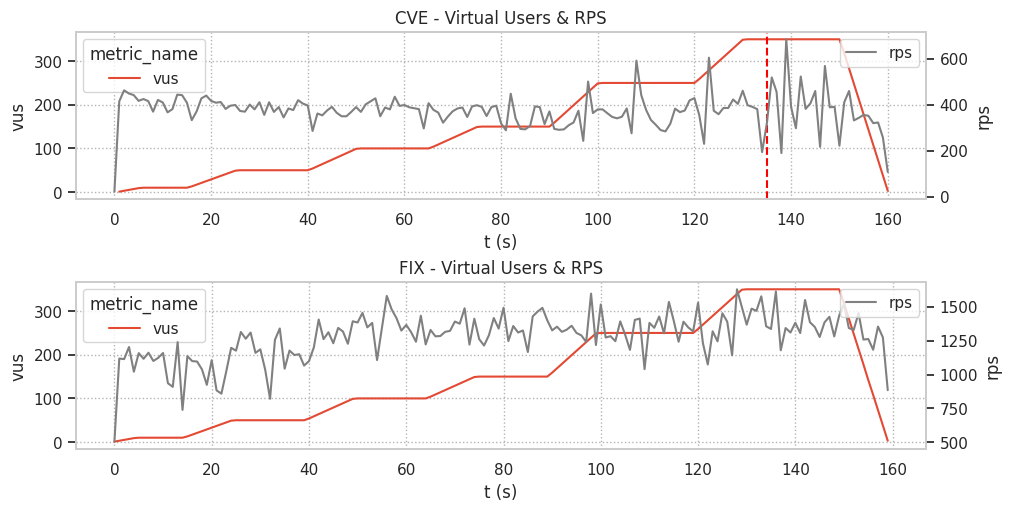

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)

metrics = ["vus"]
m_cve = df_cve_rampvus_norm['metric_name'].isin(metrics)
m_fix = df_fix_rampvus_norm['metric_name'].isin(metrics)

sns.lineplot(data=df_cve_rampvus_norm.loc[m_cve], x="t", y="metric_value", hue="metric_name", ax=axs[0])
sns.lineplot(data=df_fix_rampvus_norm.loc[m_fix], x="t", y="metric_value", hue="metric_name", ax=axs[1])

# Show saturation start
if cve_win5_sat["t_start"] is not None:
    axs[0].axvline(cve_win5_sat["t_start"], linestyle="--", color="red", label="CVE saturation start")

if fix_win5_sat["t_start"] is not None:
    axs[1].axvline(fix_win5_sat["t_start"], linestyle="--", color="red", label="FIX saturation start")

ax0_twin = axs[0].twinx()
sns.lineplot(df_cve,x="t",y="rpw",ax=ax0_twin,color="gray",label="rps")
ax0_twin.grid(axis='y', visible=False)
ax0_twin.set_ylabel("rps")
ax0_twin.legend(loc='upper right')

ax1_twin = axs[1].twinx()
sns.lineplot(df_fix,x="t",y="rpw",ax=ax1_twin,color="gray",label="rps")
ax1_twin.grid(axis='y', visible=False) 
ax1_twin.set_ylabel("rps")
ax1_twin.legend(loc='upper right')

axs[0].set_title("CVE - Virtual Users & RPS")
axs[0].set_xlabel("t (s)")
axs[0].set_ylabel("vus")
axs[1].set_title("FIX - Virtual Users & RPS")
axs[1].set_xlabel("t (s)")
axs[1].set_ylabel("vus")

plt.show()

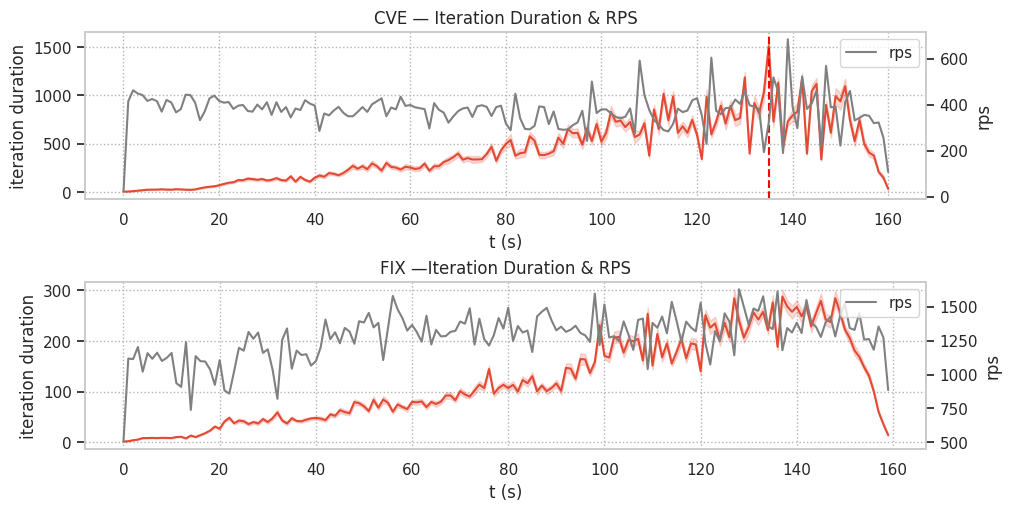

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)

metrics = ["iteration_duration"]
m_cve = df_cve_rampvus_norm['metric_name'].isin(metrics)
m_fix = df_fix_rampvus_norm['metric_name'].isin(metrics)

sns.lineplot(data=df_cve_rampvus_norm.loc[m_cve], x="t", y="metric_value", hue="metric_name", ax=axs[0], legend=False)
sns.lineplot(data=df_fix_rampvus_norm.loc[m_fix], x="t", y="metric_value", hue="metric_name", ax=axs[1], legend=False)

# Show saturation start
if cve_win5_sat["t_start"] is not None:
    axs[0].axvline(cve_win5_sat["t_start"], linestyle="--", color="red", label="CVE saturation start")

if fix_win5_sat["t_start"] is not None:
    axs[1].axvline(fix_win5_sat["t_start"], linestyle="--", color="red", label="FIX saturation start")

ax0_twin = axs[0].twinx()
sns.lineplot(df_cve,x="t",y="rpw",ax=ax0_twin,color="gray",label="rps")
ax0_twin.grid(axis='y', visible=False)
ax0_twin.set_ylabel("rps")
ax0_twin.legend(loc='upper right')

ax1_twin = axs[1].twinx()
sns.lineplot(df_fix,x="t",y="rpw",ax=ax1_twin,color="gray",label="rps")
ax1_twin.grid(axis='y', visible=False)
ax1_twin.set_ylabel("rps")
ax1_twin.legend(loc='upper right')

axs[0].set_title("CVE — Iteration Duration & RPS")
axs[0].set_xlabel("t (s)")
axs[0].set_ylabel("iteration duration")
axs[1].set_title("FIX —Iteration Duration & RPS")
axs[1].set_xlabel("t (s)")
axs[1].set_ylabel("iteration duration")

plt.show()

In [17]:
df_cve_sat_tmp = cve_win5_sat["df_p95w"][['t', 'p95']].copy()
df_cve_sat_tmp['version'] = 'cve'

df_fix_sat_tmp = fix_win5_sat["df_p95w"][['t', 'p95']].copy()
df_fix_sat_tmp['version'] = 'fix'

df_sat_compare = pd.concat([df_cve_sat_tmp, df_fix_sat_tmp], ignore_index=True)

print(f"{df_sat_compare.shape} - Saturation comparison data shape")

print(f"Columns of saturation comparison data: {df_sat_compare.columns}")

(65, 3) - Saturation comparison data shape
Columns of saturation comparison data: Index(['t', 'p95', 'version'], dtype='object')


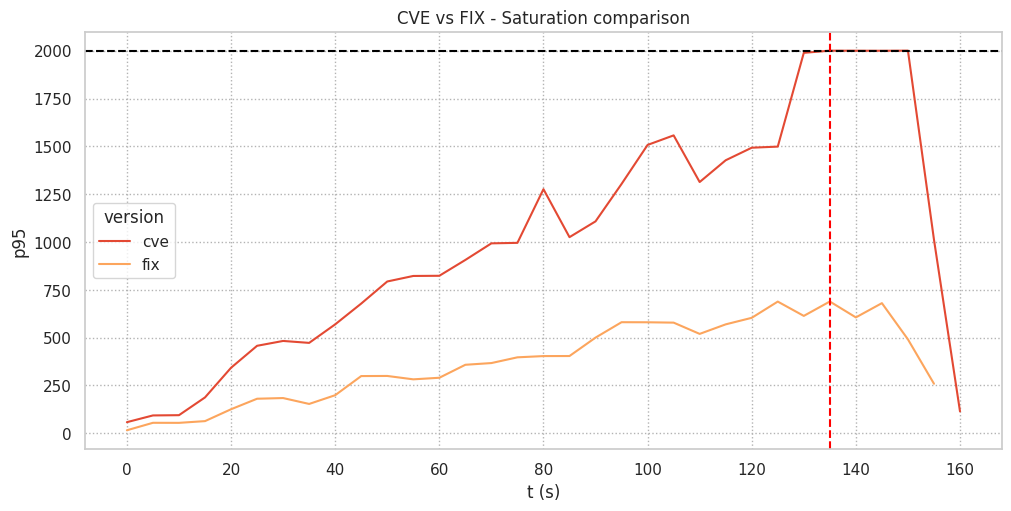

In [18]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

sns.lineplot(data=df_sat_compare, x="t", y="p95", hue="version", ax=ax)

ax.axhline(threshold_ms, linestyle="--", color="black")

# Show saturation start
if cve_win5_sat["t_start"] is not None:
    ax.axvline(cve_win5_sat["t_start"], linestyle="--", color="red", label="CVE saturation start")

ax.set_xlabel("t (s)")
ax.set_ylabel("p95")
ax.set_title("CVE vs FIX - Saturation comparison")

plt.show()

In [19]:
saturation_t = cve_win5_sat['t_start']

val = {
    'HeapAlloc_MB': (df_cve.loc[df_cve['t']==saturation_t, 'heap_alloc_mb'].mean(),
                     df_fix.loc[df_fix['t']==saturation_t, 'heap_alloc_mb'].mean()),
    'GCCPUFraction': (df_cve.loc[df_cve['t']==saturation_t, 'gc_cpu_fraction'].mean(),
                      df_fix.loc[df_fix['t']==saturation_t, 'gc_cpu_fraction'].mean()),
}

print(f"Compare values at saturation starts t={saturation_t}:")
for metric, (cve_val, fix_val) in val.items():
    print(f"{metric}: CVE={cve_val:.3f}, Fix={fix_val:.3f}, Δ={cve_val - fix_val:.3f}")

Compare values at saturation starts t=135.0:
HeapAlloc_MB: CVE=47.556, Fix=12.882, Δ=34.674
GCCPUFraction: CVE=0.190, Fix=0.134, Δ=0.056


In [20]:
df_cve_plot = df_cve[['t', 'heap_alloc_mb', 'gc_cpu_fraction']].copy()
df_cve_plot['version'] = "CVE"
df_fix_plot = df_fix[['t', 'heap_alloc_mb', 'gc_cpu_fraction']].copy()
df_fix_plot['version'] = "FIX"
df_combined = pd.concat([df_cve_plot, df_fix_plot], ignore_index=True)

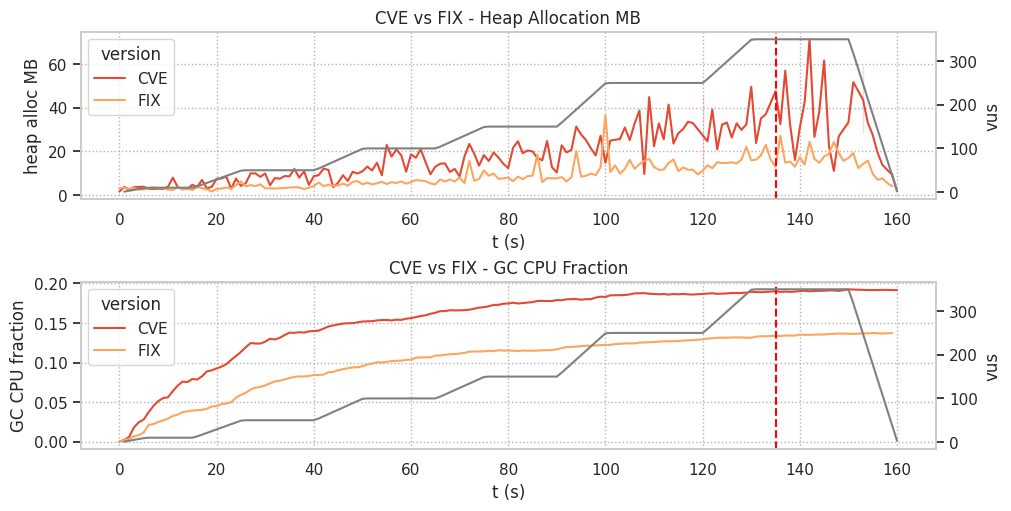

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)

sns.lineplot(data=df_combined, x="t", y="heap_alloc_mb", hue="version", ax=axs[0])
sns.lineplot(data=df_combined, x="t", y="gc_cpu_fraction", hue="version", ax=axs[1])

# Show saturation start
if cve_win5_sat['t_start'] is not None:
    axs[0].axvline(cve_win5_sat['t_start'], linestyle="--", color="red", label="CVE saturation start")
    axs[1].axvline(cve_win5_sat['t_start'], linestyle="--", color="red", label="CVE saturation start")

if fix_win5_sat['t_start'] is not None:
    axs[0].axvline(fix_win5_sat['t_start'], linestyle="--", color="orange", label="FIX saturation start")
    axs[1].axvline(fix_win5_sat['t_start'], linestyle="--", color="orange", label="FIX saturation start")

m_cve = df_cve_rampvus_norm['metric_name'].isin(["vus"])
m_fix = df_fix_rampvus_norm['metric_name'].isin(["vus"])

ax0_twin = axs[0].twinx()
sns.lineplot(df_cve_rampvus_norm.loc[m_cve], x="t", y="metric_value", ax=ax0_twin, color="gray", label="vus", linestyle="-", legend=False)
ax0_twin.grid(axis='y', visible=False)
ax0_twin.set_ylabel("vus")

ax1_twin = axs[1].twinx()
sns.lineplot(df_cve_rampvus_norm.loc[m_cve], x="t", y="metric_value", ax=ax1_twin, color="gray", label="vus", linestyle="-", legend=False)
ax1_twin.grid(axis='y', visible=False)
ax1_twin.set_ylabel("vus")

axs[0].set_title(f"CVE vs FIX - Heap Allocation MB")
axs[0].set_xlabel("t (s)")
axs[0].set_ylabel("heap alloc MB")
axs[1].set_title(f"CVE vs FIX - GC CPU Fraction")
axs[1].set_xlabel("t (s)")
axs[1].set_ylabel("GC CPU fraction")

plt.show()
